In [1]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [2]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
Directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/train"

CATEGORIES = ['Closed', 'Open', 'yawn', 'no_yawn']

# setting image size
img_size = 224
data = []

In [4]:
for category in CATEGORIES:
    folder = os.path.join(Directory, category)
    label = CATEGORIES.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        img_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image
        img_arr = np.stack((img_arr,)*3, axis=-1)  # Stack grayscale image 3 times to simulate RGB
        data.append([img_arr, label])

In [5]:
random.shuffle(data)

# Split data into features and labels
X = np.array([item[0] for item in data])
Y = np.array([item[1] for item in data])

# Save data
pickle.dump(X, open('X.pkl', 'wb'))
pickle.dump(Y, open('Y.pkl', 'wb'))

# Normalize image array
X = X / 255.0

In [8]:
from keras.applications import ResNet50

Resnet50_local_weights_path ='imagenet'

# Load the ResNet50 model, excluding the top layers
Resnet50_base_model = ResNet50(weights=Resnet50_local_weights_path, include_top=False, input_shape=(img_size, img_size, 3))

# Add custom top layers
x = Resnet50_base_model.output
x = GlobalAveragePooling2D()(x)  # Using GlobalAveragePooling for better handling of spatial hierarchies
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

# Create the new model
Resnet50_model = Model(inputs=Resnet50_base_model.input, outputs=x)

# Optionally freeze the layers of the base model
for layer in Resnet50_base_model.layers:
    layer.trainable = True

# Compile the model
Resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
Resnet50_history = Resnet50_model.fit(X, Y, epochs=15, validation_split=0.2, batch_size=32)

94765736/94765736 [==============================] - 47s 1us/step
Epoch 1/15


62/62 [==============================] - 266s 4s/step - loss: 0.3883 - accuracy: 0.8824 - val_loss: 25257.7754 - val_accuracy: 0.2348
Epoch 2/15
62/62 [==============================] - 259s 4s/step - loss: 0.1720 - accuracy: 0.9534 - val_loss: 5.0499 - val_accuracy: 0.2429
Epoch 3/15
62/62 [==============================] - 263s 4s/step - loss: 0.1536 - accuracy: 0.9539 - val_loss: 5.1437 - val_accuracy: 0.2429
Epoch 4/15
62/62 [==============================] - 263s 4s/step - loss: 0.0646 - accuracy: 0.9848 - val_loss: 3.2190 - val_accuracy: 0.2429
Epoch 5/15
62/62 [==============================] - 263s 4s/step - loss: 0.0526 - accuracy: 0.9843 - val_loss: 2.8464 - val_accuracy: 0.2429
Epoch 6/15
62/62 [==============================] - 264s 4s/step - loss: 0.0298 - accuracy: 0.9909 - val_loss: 2.5735 - val_accuracy: 0.2429
Epoch 7/15
62/62 [==============================] - 262s 4s/step - loss: 0.0282 - 

14/14 [==============================] - 15s 1s/step - loss: 0.5366 - accuracy: 0.8314
Test Accuracy: 0.8314087986946106


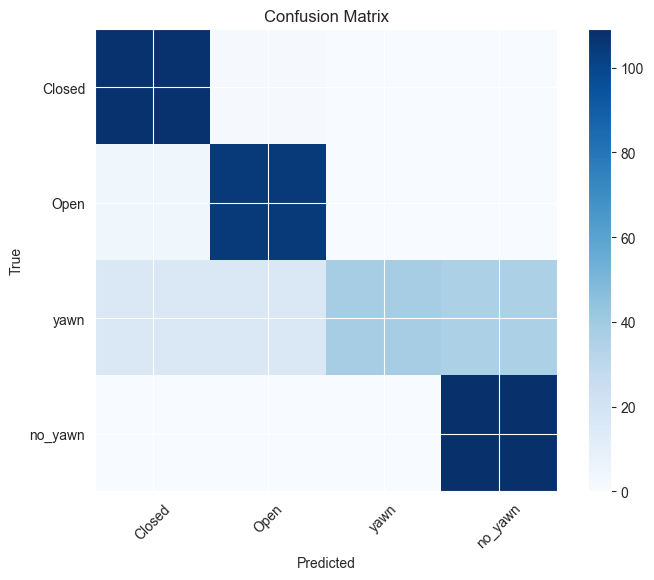

Classification Report:
              precision    recall  f1-score   support

      Closed       0.84      0.99      0.91       109
        Open       0.86      0.96      0.91       109
        yawn       1.00      0.36      0.53       106
     no_yawn       0.75      1.00      0.86       109

    accuracy                           0.83       433
   macro avg       0.86      0.83      0.80       433
weighted avg       0.86      0.83      0.80       433



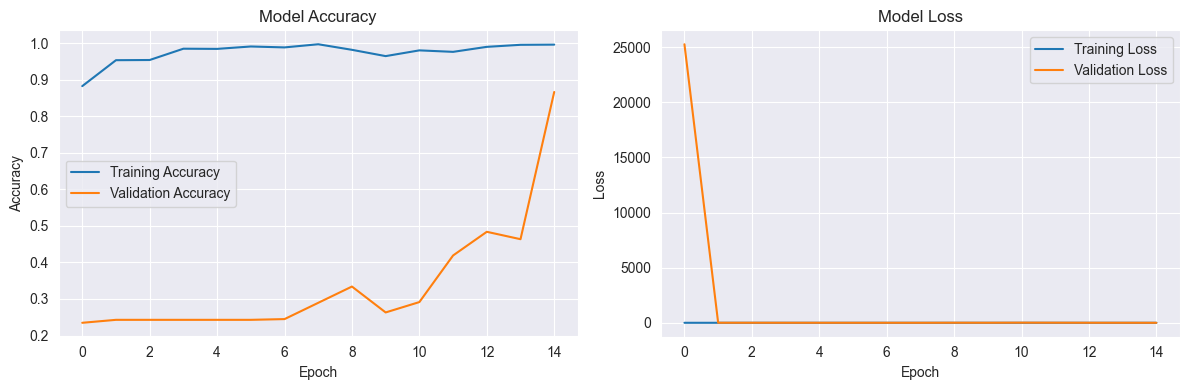

In [10]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Update the path to the test dataset directory
test_directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/test"

CATEGORIES_TEST = ['Closed', 'Open', 'yawn', 'no_yawn']

# Load and preprocess test images and labels
test_images = []
test_labels = []

for category in CATEGORIES_TEST:
    folder = os.path.join(test_directory, category)
    label = CATEGORIES_TEST.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        img_arr = cv2.resize(img_arr, (224, 224))  # Resize image
        img_arr = np.stack((img_arr,)*3, axis=-1)  # Stack grayscale image 3 times to simulate RGB
        test_images.append(img_arr)
        test_labels.append(label)

# Convert to arrays
test_images = np.array(test_images)/255.0
test_labels = np.array(test_labels)

# Make predictions on the test data
Resnet50_predictions = Resnet50_model.predict(test_images)

# Evaluate model performance on test data
test_loss, test_accuracy = Resnet50_model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')

# Confusion Matrix
y_pred = np.argmax(Resnet50_predictions, axis=1)
cm = confusion_matrix(test_labels, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(CATEGORIES_TEST))
plt.xticks(tick_marks, CATEGORIES_TEST, rotation=45)
plt.yticks(tick_marks, CATEGORIES_TEST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=CATEGORIES_TEST))

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(Resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(Resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Resnet50_history.history['loss'], label='Training Loss')
plt.plot(Resnet50_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show() 

1/1 [==============================] - 0s 99ms/step


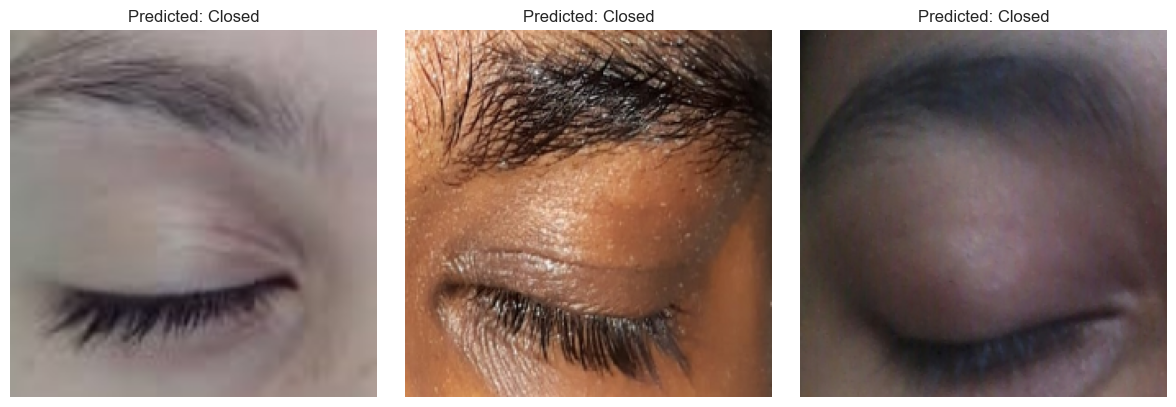

In [11]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Update the path to the test dataset directory
Directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/test"

CATEGORIES = ['Closed', 'Open', 'yawn', 'no_yawn']


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    # Choose a random category and image
    category = random.choice(CATEGORIES)
    folder = os.path.join(Directory, category)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Preprocess the image for prediction
    resized_img = cv2.resize(img, (224, 224))  # Assuming model was trained on 24x24 images
    input_img = np.expand_dims(resized_img, axis=0) / 255.0  # Normalize and add batch dimension

    # Make predictions
    Resnet50_predictions = Resnet50_model.predict(input_img)
    Resnet50_prediction = CATEGORIES[np.argmax( Resnet50_predictions)]

    # Display the image and model's interpretation
    ax = axes[i]
    ax.imshow(resized_img)
    ax.set_title(f"Predicted: {Resnet50_prediction}")
    ax.axis('off')

plt.tight_layout()
plt.show()

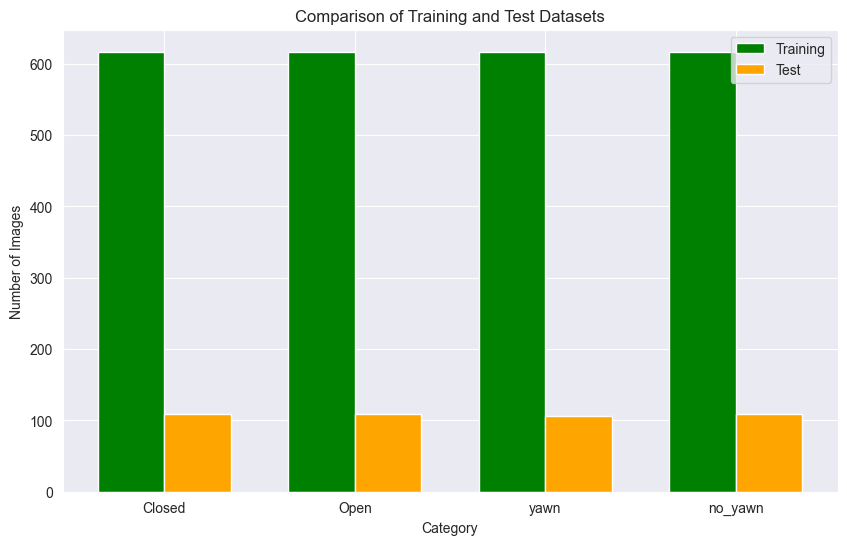

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to the training and test datasets
train_directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/train"
test_directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/test"

# Categories for the dataset
CATEGORIES_TEST = ['Closed', 'Open', 'yawn', 'no_yawn']

# Count the number of images in each category in the training dataset
train_counts = [len(os.listdir(os.path.join(train_directory, category))) for category in CATEGORIES_TEST]

# Count the number of images in each category in the test dataset
test_counts = [len(os.listdir(os.path.join(test_directory, category))) for category in CATEGORIES_TEST]

# Plot grouped bar chart for both training and test datasets
bar_width = 0.35
index = np.arange(len(CATEGORIES_TEST))

plt.figure(figsize=(10, 6))
plt.bar(index, train_counts, bar_width, label='Training', color='green')
plt.bar(index + bar_width, test_counts, bar_width, label='Test', color='orange')

plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Comparison of Training and Test Datasets')
plt.xticks(index + bar_width / 2, CATEGORIES_TEST)
plt.legend()
plt.show()

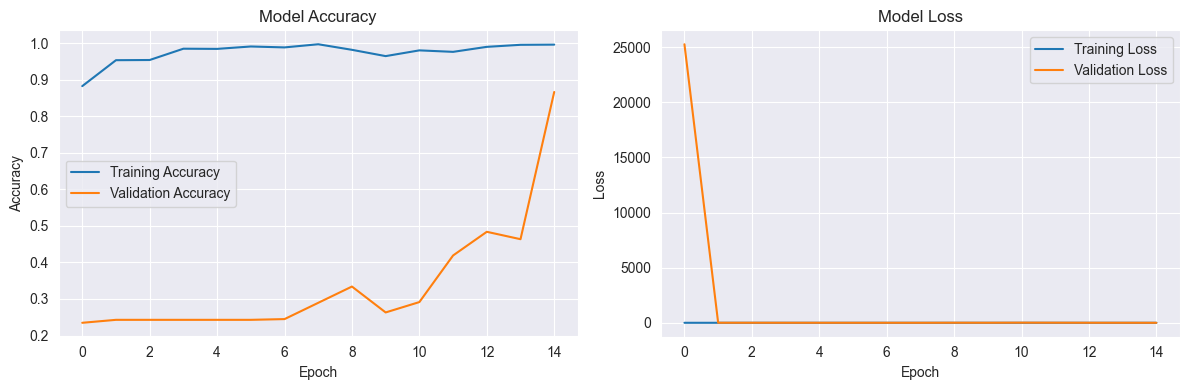

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(Resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(Resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Resnet50_history.history['loss'], label='Training Loss')
plt.plot(Resnet50_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(Resnet50_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
Resnet50_model.save('c:/Users/Dareen/OneDrive/Desktop/graduation/yawn_model2.h5')

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

VGG16_local_weights_path = "C:/Users/Dareen/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Load VGG16 model pre-trained on ImageNet without the top layer
VGG16_base_model = VGG16(weights=VGG16_local_weights_path, include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base model
for layer in VGG16_base_model.layers:
    layer.trainable = True

# Create new top layers
x = VGG16_base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(CATEGORIES), activation='softmax')(x)

# Compile the model
VGG16_model = Model(inputs=VGG16_base_model.input, outputs=x)
VGG16_model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
VGG16_history = VGG16_model.fit(X, Y, epochs=15, validation_split=0.2, batch_size=32)

Epoch 1/15
62/62 [==============================] - 869s 14s/step - loss: 1.4547 - accuracy: 0.4394 - val_loss: 0.6594 - val_accuracy: 0.5850
Epoch 2/15
62/62 [==============================] - 878s 14s/step - loss: 0.6685 - accuracy: 0.6178 - val_loss: 0.4816 - val_accuracy: 0.7834
Epoch 3/15
62/62 [==============================] - 879s 14s/step - loss: 0.4895 - accuracy: 0.7456 - val_loss: 0.4456 - val_accuracy: 0.8057
Epoch 4/15
62/62 [==============================] - 879s 14s/step - loss: 0.5297 - accuracy: 0.7369 - val_loss: 0.6572 - val_accuracy: 0.6943
Epoch 5/15
62/62 [==============================] - 886s 14s/step - loss: 0.4656 - accuracy: 0.7522 - val_loss: 0.3790 - val_accuracy: 0.8219
Epoch 6/15
62/62 [==============================] - 869s 14s/step - loss: 0.3900 - accuracy: 0.7942 - val_loss: 0.8210 - val_accuracy: 0.7267
Epoch 7/15
62/62 [==============================] - 971s 16s/step - loss: 0.5485 - accuracy: 0.7496 - val_loss: 0.3985 - val_accuracy: 0.7753
Epoch 

14/14 [==============================] - 41s 3s/step - loss: 0.2960 - accuracy: 0.8453
Test Accuracy: 0.8452655673027039


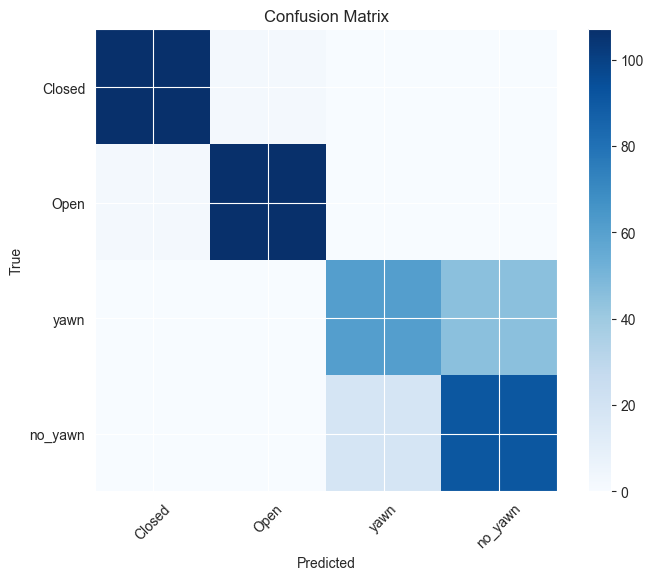

Classification Report:
              precision    recall  f1-score   support

      Closed       0.98      0.98      0.98       109
        Open       0.98      0.98      0.98       109
        yawn       0.77      0.58      0.66       106
     no_yawn       0.67      0.83      0.74       109

    accuracy                           0.85       433
   macro avg       0.85      0.84      0.84       433
weighted avg       0.85      0.85      0.84       433



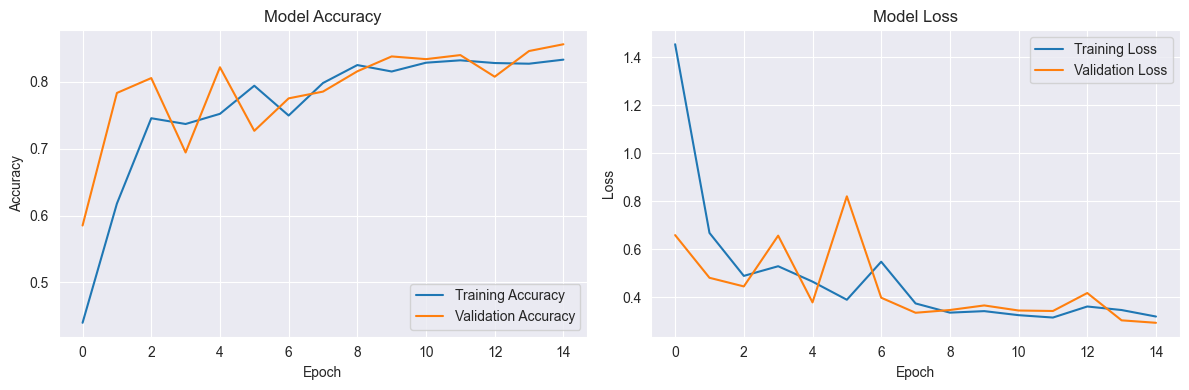

In [19]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Update the path to the test dataset directory
test_directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/test"

CATEGORIES_TEST = ['Closed', 'Open', 'yawn', 'no_yawn']

# Load and preprocess test images and labels
test_images = []
test_labels = []

for category in CATEGORIES_TEST:
    folder = os.path.join(test_directory, category)
    label = CATEGORIES_TEST.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        img_arr = cv2.resize(img_arr, (224, 224))  # Resize image
        img_arr = np.stack((img_arr,)*3, axis=-1)  # Stack grayscale image 3 times to simulate RGB
        test_images.append(img_arr)
        test_labels.append(label)

# Convert to arrays
test_images = np.array(test_images)/255.0
test_labels = np.array(test_labels)

# Make predictions on the test data
VGG16_predictions = VGG16_model.predict(test_images)

# Evaluate model performance on test data
test_loss, test_accuracy = VGG16_model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')

# Confusion Matrix
y_pred = np.argmax(VGG16_predictions, axis=1)
cm = confusion_matrix(test_labels, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(CATEGORIES_TEST))
plt.xticks(tick_marks, CATEGORIES_TEST, rotation=45)
plt.yticks(tick_marks, CATEGORIES_TEST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=CATEGORIES_TEST))

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(VGG16_history.history['accuracy'], label='Training Accuracy')
plt.plot(VGG16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(VGG16_history.history['loss'], label='Training Loss')
plt.plot(VGG16_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 132ms/step


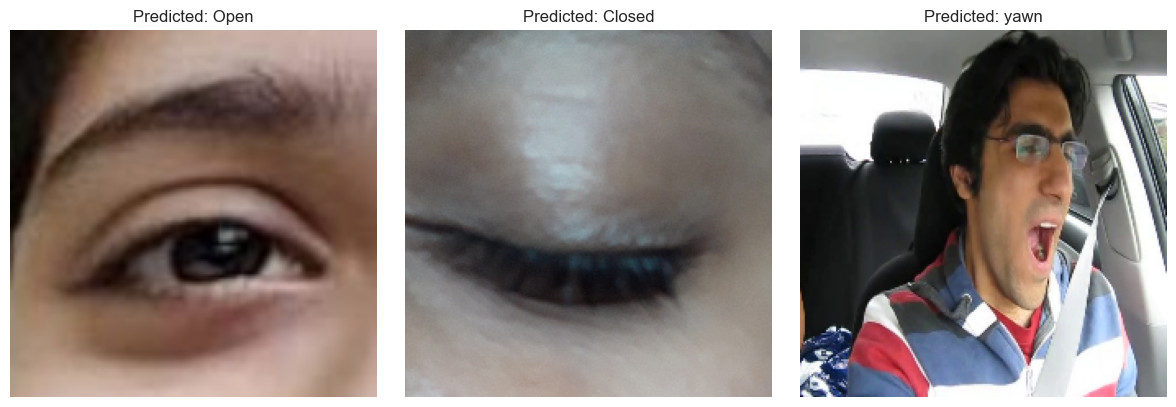

In [20]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Update the path to the test dataset directory
Directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/test"


CATEGORIES = ['Closed', 'Open', 'yawn', 'no_yawn']


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    # Choose a random category and image
    category = random.choice(CATEGORIES)
    folder = os.path.join(Directory, category)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Preprocess the image for prediction
    resized_img = cv2.resize(img, (224, 224))  # Assuming model was trained on 24x24 images
    input_img = np.expand_dims(resized_img, axis=0) / 255.0  # Normalize and add batch dimension

    # Make predictions
    VGG16_predictions = VGG16_model.predict(input_img)
    VGG16_prediction = CATEGORIES[np.argmax(VGG16_predictions)]

    # Display the image and model's interpretation
    ax = axes[i]
    ax.imshow(resized_img)
    ax.set_title(f"Predicted: {VGG16_prediction}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [21]:
VGG16_model.save('c:/Users/Dareen/OneDrive/Desktop/graduation/yawn_model3.h5')

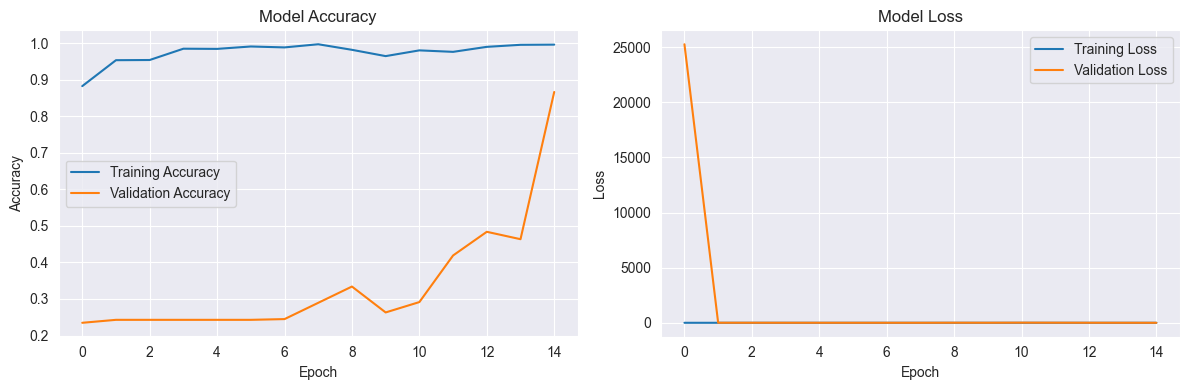

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(Resnet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(Resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Resnet50_history.history['loss'], label='Training Loss')
plt.plot(Resnet50_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

InceptionV3_local_weights_path = "C:/Users/Dareen/Downloads/archive (10)/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Load Inception V3 model pre-trained on ImageNet without the top layer
InceptionV3_base_model = InceptionV3(weights=InceptionV3_local_weights_path, include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base model
for layer in InceptionV3_base_model.layers:
    layer.trainable = True

# Create new top layers
x = InceptionV3_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(CATEGORIES), activation='softmax')(x)

# Compile the model
InceptionV3_model = Model(inputs=InceptionV3_base_model.input, outputs=x)
InceptionV3_model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
InceptionV3_history = InceptionV3_model.fit(X, Y, epochs=15, validation_split=0.2, batch_size=32)

Epoch 1/15
62/62 [==============================] - 175s 3s/step - loss: 0.2606 - accuracy: 0.9093 - val_loss: 101.0903 - val_accuracy: 0.2591
Epoch 2/15
62/62 [==============================] - 156s 3s/step - loss: 0.0976 - accuracy: 0.9655 - val_loss: 0.3044 - val_accuracy: 0.9372
Epoch 3/15
62/62 [==============================] - 157s 3s/step - loss: 0.0476 - accuracy: 0.9873 - val_loss: 1.5825 - val_accuracy: 0.8401
Epoch 4/15
62/62 [==============================] - 162s 3s/step - loss: 0.0593 - accuracy: 0.9848 - val_loss: 0.4447 - val_accuracy: 0.9312
Epoch 5/15
62/62 [==============================] - 159s 3s/step - loss: 0.0215 - accuracy: 0.9949 - val_loss: 0.0087 - val_accuracy: 0.9960
Epoch 6/15
62/62 [==============================] - 158s 3s/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 6.3415e-04 - val_accuracy: 1.0000
Epoch 7/15
62/62 [==============================] - 158s 3s/step - loss: 0.0128 - accuracy: 0.9949 - val_loss: 3.4545 - val_accuracy: 0.5506
Epoch 8

14/14 [==============================] - 7s 475ms/step - loss: 0.0075 - accuracy: 0.9977
Test Accuracy: 0.9976905584335327


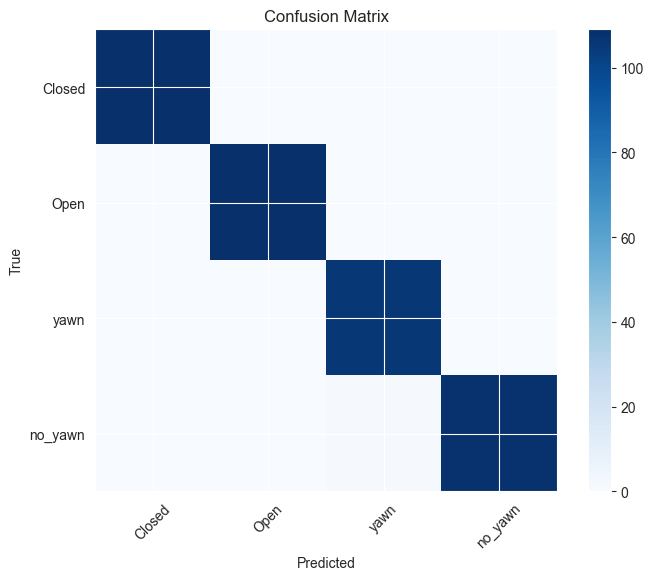

Classification Report:
              precision    recall  f1-score   support

      Closed       1.00      1.00      1.00       109
        Open       1.00      1.00      1.00       109
        yawn       0.99      1.00      1.00       106
     no_yawn       1.00      0.99      1.00       109

    accuracy                           1.00       433
   macro avg       1.00      1.00      1.00       433
weighted avg       1.00      1.00      1.00       433



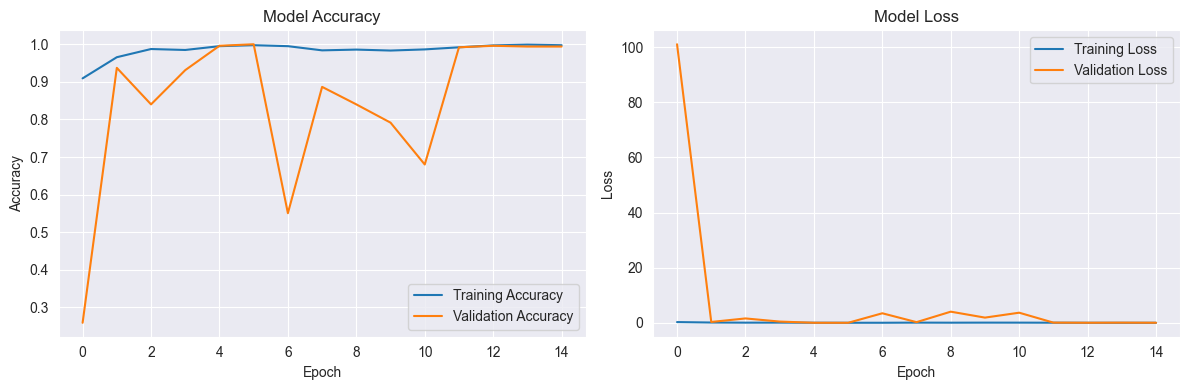

In [24]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Update the path to the test dataset directory
test_directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/test"

CATEGORIES_TEST = ['Closed', 'Open', 'yawn', 'no_yawn']

# Load and preprocess test images and labels
test_images = []
test_labels = []

for category in CATEGORIES_TEST:
    folder = os.path.join(test_directory, category)
    label = CATEGORIES_TEST.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        img_arr = cv2.resize(img_arr, (224, 224))  # Resize image
        img_arr = np.stack((img_arr,)*3, axis=-1)  # Stack grayscale image 3 times to simulate RGB
        test_images.append(img_arr)
        test_labels.append(label)

# Convert to arrays
test_images = np.array(test_images)/255.0
test_labels = np.array(test_labels)

# Make predictions on the test data
InceptionV3_predictions = InceptionV3_model.predict(test_images)

# Evaluate model performance on test data
test_loss, test_accuracy = InceptionV3_model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')

# Confusion Matrix
y_pred = np.argmax(InceptionV3_predictions, axis=1)
cm = confusion_matrix(test_labels, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(CATEGORIES_TEST))
plt.xticks(tick_marks, CATEGORIES_TEST, rotation=45)
plt.yticks(tick_marks, CATEGORIES_TEST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=CATEGORIES_TEST))

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(InceptionV3_history.history['accuracy'], label='Training Accuracy')
plt.plot(InceptionV3_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(InceptionV3_history.history['loss'], label='Training Loss')
plt.plot(InceptionV3_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 68ms/step


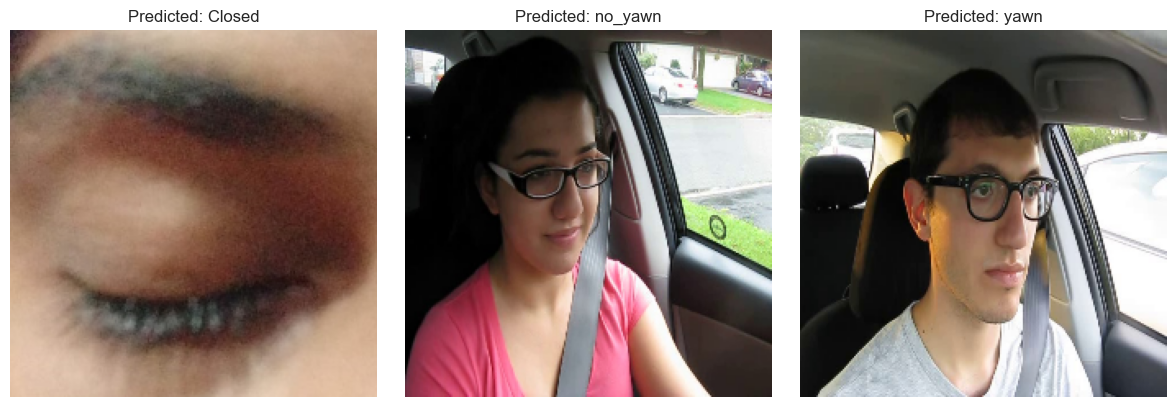

In [25]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Update the path to the test dataset directory
Directory = "C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_detection/dataset_new/test"

CATEGORIES = ['Closed', 'Open', 'yawn', 'no_yawn']


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    # Choose a random category and image
    category = random.choice(CATEGORIES)
    folder = os.path.join(Directory, category)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Preprocess the image for prediction
    resized_img = cv2.resize(img, (224, 224))  # Assuming model was trained on 24x24 images
    input_img = np.expand_dims(resized_img, axis=0) / 255.0  # Normalize and add batch dimension

    # Make predictions
    InceptionV3_predictions = InceptionV3_model.predict(input_img)
    InceptionV3_prediction = CATEGORIES[np.argmax(InceptionV3_predictions)]

    # Display the image and model's interpretation
    ax = axes[i]
    ax.imshow(resized_img)
    ax.set_title(f"Predicted: {InceptionV3_prediction}")
    ax.axis('off')

plt.tight_layout()
plt.show()


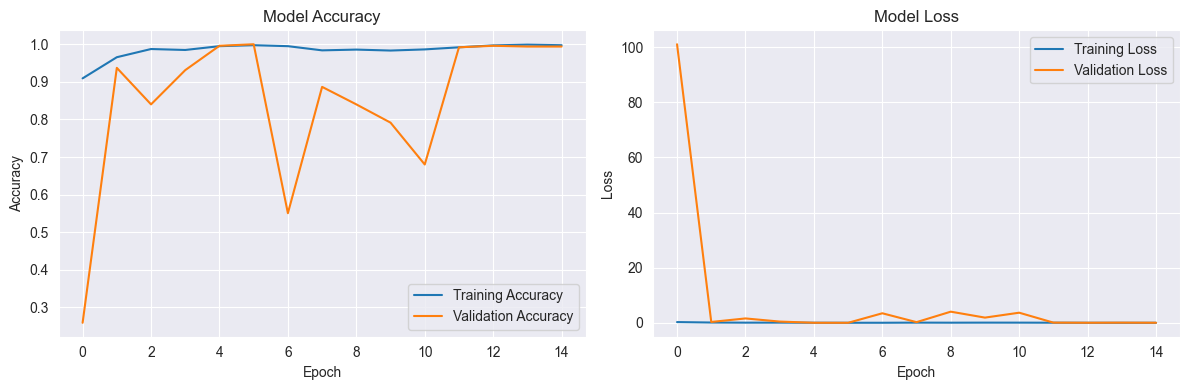

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(InceptionV3_history.history['accuracy'], label='Training Accuracy')
plt.plot(InceptionV3_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(InceptionV3_history.history['loss'], label='Training Loss')
plt.plot(InceptionV3_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
InceptionV3_model.save("C:/Users/Dareen/OneDrive/Desktop/graduation/yawn_model4.h5")